# Neural networks - Homework (minimal)

In [1]:
import gc
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

import keras
from keras.callbacks import Callback, History
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils, to_categorical

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

Using TensorFlow backend.


TensorFlow version: 1.13.1
Keras version: 2.2.4


# Writing utility code

In [2]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, verbose=True):
        self.cols = cols
        self.mappings = {}
        self.verbose = verbose

    def fit(self, X, y=None):
        for col in self.cols:
            if self.verbose:
                print('Fitting frequency-encoded column: %s' % col)
            self.mappings[col] = X[col].value_counts().to_dict()
        return self

    def transform(self, X):
        for col in self.cols:
            if self.verbose:
                print('Transforming frequency-encoded column: %s' % col)
            X[col] = X[col].map(lambda x: self.mappings[col].get(x, np.nan)).astype('float32')
        return X
    
def test_frequency_encoder():
    df1 = pd.DataFrame({
        'a': ['a', 'b', 'b', 'c', 'c', 'c', np.nan],
    })
    df2 = pd.DataFrame({
        'a': ['a', 'd'],
    })
    encoder = FrequencyEncoder(cols=['a'], verbose=False)
    result1 = encoder.fit_transform(df1)
    result2 = encoder.transform(df2)
    expected1 = pd.DataFrame({
        'a': [1.0, 2.0, 2.0, 3.0, 3.0, 3.0, np.nan],
    }, dtype='float32')
    expected2 = pd.DataFrame({
        'a': [1.0, np.nan],
    }, dtype='float32')

    assert result1.equals(expected1)
    assert result2.equals(expected2)

test_frequency_encoder()

In [3]:
from matplotlib.ticker import MaxNLocator

class TrainingHistory(keras.callbacks.Callback):
    """
    Class to accumulate and plot metrics.
    Can be used separately or as a Keras callback.
    """
    def __init__(self, metric='acc', metric_name='Accuracy'):
        super().__init__()
        self.metric = metric
        self.metric_name = metric_name
        self.train_loss_list = []
        self.train_metric_list = []
        self.test_loss_list = []
        self.test_metric_list = []

    def on_epoch_end(self, batch, logs={}):
        self.train_loss_list.append(logs.get('loss'))
        self.test_loss_list.append(logs.get('val_loss'))
        self.train_metric_list.append(logs.get(self.metric))
        self.test_metric_list.append(logs.get('val_%s' % self.metric))
        
        epoch_num = len(self.train_loss_list)
        if epoch_num % 10 == 0:
            print('Epoch {0}: loss={1} {2}={3:.4f}'.format(epoch_num, self.train_loss_list[-1],
                                                           self.metric, self.train_metric_list[-1]))
    
    def print_scores(self):
        
        print('{0}: train={1:.4f}, test={2:.4f}'.format(self.metric_name,
                                                        self.train_metric_list[-1],
                                                        self.test_metric_list[-1]))
        print('Loss: train={0:.4f}, test={1:.4f}'.format(self.train_loss_list[-1],
                                                         self.test_loss_list[-1]))
            
    def plot(self):
        f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        plt.subplots_adjust(wspace=0.2, hspace=0.2)

        axes[0].set_title('Loss', fontsize=16, fontweight='bold')
        axes[1].set_title(self.metric_name, fontsize=16, fontweight='bold')

        axes[0].plot(self.train_loss_list, label='Train set')
        axes[0].plot(self.test_loss_list, label='Test set')

        axes[1].plot(self.train_metric_list, label='Train set')
        axes[1].plot(self.test_metric_list, label='Test set')

        axes[0].set_xlabel("Epoch")
        axes[1].set_xlabel("Epoch")

        # Only integer epoch labels
        axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

        axes[0].legend()
        axes[1].legend()

In [4]:
def show_class_histogram(df, col='Class'):
    total = float(len(df))
    ax = sns.countplot(x=col, data=df)

    for p in ax.patches:
        height = p.get_height() # bar integer value (not pixels here!)
        height = 0 if np.isnan(height) else height
        ax.text(
            p.get_x() + p.get_width()/2, height, 
            '{0} ({1:1.2f}%)'.format(height, height * 100/total), ha="center"
        )
    ax.set_title('Distribution of target class', fontsize=14, fontweight='bold')
    plt.show()

# Titanic dataset (binary classification)

## Preprocessing the data

Things done here:
- imputing missing values
- encoding categorical variables (one-hot for low-cardinality, frequency encoding for high-cardinality)

In [5]:
df = pd.read_csv('titanic3.csv') #, na_values='?', true_values='t', false_values='f')
df.dropna(axis=0, how='all', inplace=True)

df['sex'] = df['sex'].map({'male': 1, 'female': 0}).astype('float64')
df['age'] = df['age'].fillna(df['age'].mean())
df['fare'] = df['fare'].fillna(df['fare'].mean())
df['cabin_count'] = df['cabin'].map(lambda x: 0 if pd.isnull(x) else len(x.split(' ')))
df['cabin_class'] = df['cabin'].map(lambda x: '0' if pd.isnull(x) else x[0])
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df.drop(['cabin'], inplace=True, axis=1)
df.drop(['name', 'home.dest'], inplace=True, axis=1) # irrelevant
df.drop(['boat', 'body'], inplace=True, axis=1)   # too much missing?

pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(cols=['pclass', 'embarked', 'cabin_class'], handle_unknown='ignore', use_cat_names=True)),
    ('freq', FrequencyEncoder(cols=['ticket'])),
])

df = pipe.fit_transform(df)

Fitting frequency-encoded column: ticket
Transforming frequency-encoded column: ticket


No resampling required.

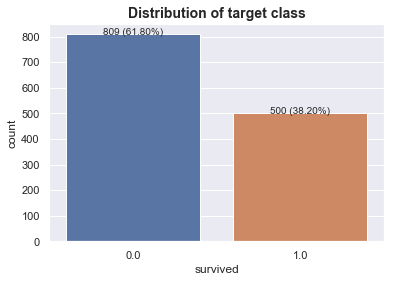

In [6]:
show_class_histogram(df, col='survived')

Split into train/test set:

In [7]:
target = df['survived']
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('survived', axis=1), target, stratify=target, random_state=42
)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
print('X shape:', X_train.shape)
print('Y shape:', y_train.shape)

X shape: (981, 22)
Y shape: (981,)


## TensorFlow model (logistic regression) for Titanic

In [9]:
batch_size = 20
learning_rate = 0.01
alpha = 0.3    # regularization
n_epochs = 50

In [10]:
tf.reset_default_graph()

num_examples = X_train.shape[0]
num_input_neurons = X_train.shape[1]

# Step 2: create placeholders for features and labels
X = tf.placeholder(tf.float32, [batch_size, num_input_neurons], name='image') 
Y = tf.placeholder(tf.float32, [batch_size, 1], name='label')

# Step 3: create weights and bias
w = tf.get_variable(name='weights', shape=(num_input_neurons, 1), initializer=tf.random_normal_initializer())
b = tf.get_variable(name='bias', shape=(1,), initializer=tf.zeros_initializer())

# Step 4: build model
logits = tf.matmul(X, w) + b 

# Step 5: define loss function
entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y, name='loss')
loss = tf.reduce_mean(entropy) + alpha * tf.nn.l2_loss(w)

# Step 6: define training op
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Step 7: calculate accuracy with test set
preds = tf.nn.sigmoid(logits)
correct_preds = tf.cast(tf.equal(tf.round(preds), Y), dtype=tf.float32)
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))


def fit_epoch(X_data, y_data):
    num_examples = X_data.shape[0]
    n_batches = int(num_examples/batch_size)
    
    for j in range(n_batches):
        X_batch = X_data[batch_size * j: batch_size * (j + 1)]
        Y_batch = y_data[batch_size * j: batch_size * (j + 1)]
        Y_batch = Y_batch.values.reshape(Y_batch.shape[0], 1)
        sess.run([optimizer], {X: X_batch, Y:Y_batch})

    
def evaluate(X_data, y_data):
    num_examples = X_data.shape[0]
    n_batches = int(num_examples/batch_size)
    
    total_loss = 0
    total_correct_preds = 0

    for i in range(n_batches):
        
        X_batch = X_data[batch_size * i: batch_size * (i + 1)]
        Y_batch = y_data[batch_size * i: batch_size * (i + 1)]
        Y_batch = Y_batch.values.reshape(Y_batch.shape[0], 1)

        loss_batch, accuracy_batch = sess.run([loss, accuracy], {X: X_batch, Y:Y_batch})
        total_loss += loss_batch
        total_correct_preds += accuracy_batch
    
    return total_loss, total_correct_preds/num_examples

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    
    history = TrainingHistory()

    for i in range(n_epochs): 
        fit_epoch(X_train, y_train)

        train_loss, train_accuracy = evaluate(X_train, y_train)
        test_loss, test_accuracy = evaluate(X_test, y_test)

        history.train_loss_list.append(train_loss)
        history.train_metric_list.append(train_accuracy)
        history.test_loss_list.append(test_loss)
        history.test_metric_list.append(test_accuracy)

        if i % 10 == 0:
            print('Epoch {0}: loss={1} accuracy={2}'.format(i, train_loss, train_accuracy))

Epoch 0: loss=104.44560861587524 accuracy=0.6890927624872579
Epoch 10: loss=27.61319264769554 accuracy=0.7686034658511722
Epoch 20: loss=27.612486600875854 accuracy=0.7726809378185525
Epoch 30: loss=27.613747149705887 accuracy=0.7737003058103975
Epoch 40: loss=27.61442205309868 accuracy=0.7737003058103975


Accuracy: train=0.7737, test=0.7713
Loss: train=27.6148, test=8.7312


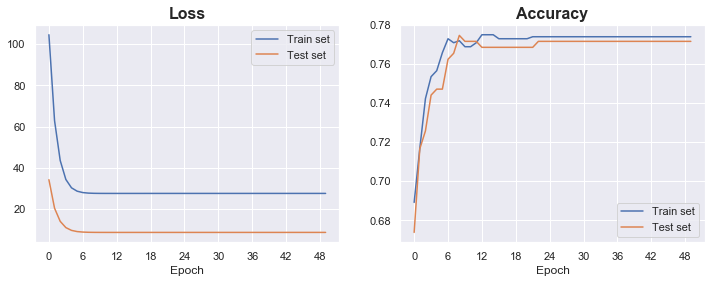

In [12]:
history.print_scores()
history.plot()
plt.show()

## Keras model (logistic regression) for Titanic

In [14]:
from keras import backend as K; K.clear_session() # TODO: fix this
tf.reset_default_graph()

adam = keras.optimizers.Adam()

model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', activity_regularizer=l2(0.01)))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)

history = TrainingHistory()

model.fit(
    X_train, y_train, epochs=100, batch_size=batch_size, verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)

score, accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
print("\nTrain Score = {:.2f}".format(score))
print("Train Accuracy = {:.2f}".format(accuracy))

score, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("\nTest Score = {:.2f}".format(score))
print("Test Accuracy = {:.2f}".format(accuracy))

Instructions for updating:
Use tf.cast instead.
Epoch 10: loss=0.5843544815962225 acc=0.7492
Epoch 20: loss=0.5309615874934512 acc=0.7829
Epoch 30: loss=0.5145005140829524 acc=0.7890
Epoch 40: loss=0.50820195495657 acc=0.7982
Epoch 50: loss=0.5050912076924433 acc=0.7982
Epoch 60: loss=0.5033542274076883 acc=0.8002
Epoch 70: loss=0.502282050103101 acc=0.8002
Epoch 80: loss=0.5018171038664687 acc=0.8022
Epoch 90: loss=0.501654351918097 acc=0.8012
Epoch 100: loss=0.5015944012048655 acc=0.8022

Train Score = 0.50
Train Accuracy = 0.80

Test Score = 0.49
Test Accuracy = 0.79


Accuracy: train=0.8022, test=0.7896
Loss: train=0.5016, test=0.4897


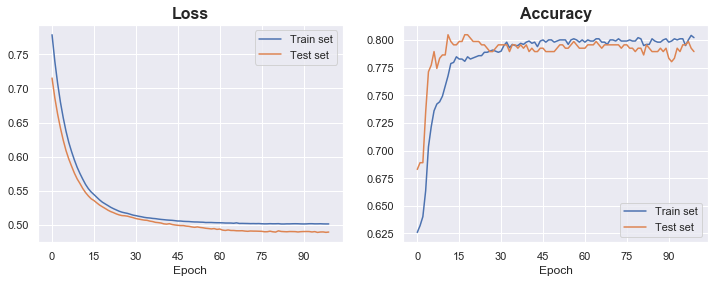

In [15]:
history.print_scores()
history.plot()
plt.show()

## Keras model (multilayer neural network) for Titanic

Things to mention:
- Excessive number of layers/neurons was chosen deliberately. However the test set score never get higher than 0.82 (which is still higher than 0.79 of simple logistic regression)
- Dropout was used instead of L2 regularization to prevent overfitting (it works better giving higher score)
- Early stopping was used to choose the number of iteration. Possible we could resort to lowering `learning_rate` instead.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 10: loss=0.5100974472776951 acc=0.7706
Epoch 20: loss=0.4728837868732293 acc=0.8002
Epoch 30: loss=0.44955443290881547 acc=0.8043
Epoch 40: loss=0.4475880456323167 acc=0.8043
Epoch 50: loss=0.42583448502874033 acc=0.8216
Epoch 60: loss=0.42156033930307013 acc=0.8175
Epoch 70: loss=0.4238371553163402 acc=0.8216

Accuracy: train=0.8298, test=0.8140
Loss: train=0.4208, test=0.4278


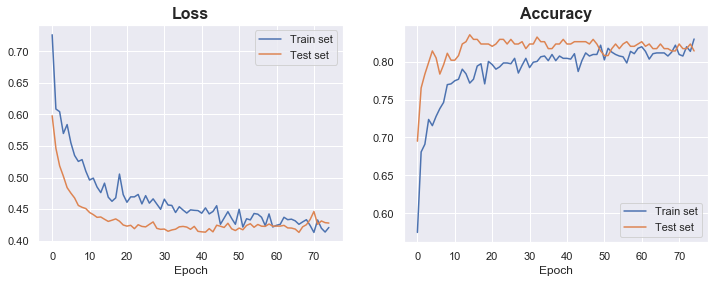

In [16]:
from keras import backend as K; K.clear_session() # TODO: fix this
tf.reset_default_graph()

adam = keras.optimizers.Adam()

model = Sequential()
model.add(Dense(80, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)

history = TrainingHistory()

model.fit(
    X_train, y_train, epochs=75, batch_size=batch_size, verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)

print()
history.print_scores()
history.plot()
plt.show()

# Thyroid dataset (multiclass classification with logistic regression)

## Preprocessing

In [17]:
df = pd.read_csv('dataset_57_hypothyroid.csv', na_values='?', true_values='t', false_values='f')
df.drop(['TBG_measured', 'TBG', 'referral_source'], inplace=True, axis=1)
df.drop(['hypopituitary'], inplace=True, axis=1)
df['Class'] = df['Class'].str.slice(0,3)
df['sex'] = df['sex'].map({'M': True, 'F': False})

df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,Class
0,41.0,False,False,False,False,False,False,False,False,False,...,1.30,True,2.5,True,125.0,True,1.14,True,109.0,neg
1,23.0,False,False,False,False,False,False,False,False,False,...,4.10,True,2.0,True,102.0,False,NaN,False,NaN,neg
2,46.0,True,False,False,False,False,False,False,False,False,...,0.98,False,NaN,True,109.0,True,0.91,True,120.0,neg
3,70.0,False,True,False,False,False,False,False,False,False,...,0.16,True,1.9,True,175.0,False,NaN,False,NaN,neg
4,70.0,False,False,False,False,False,False,False,False,False,...,0.72,True,1.2,True,61.0,True,0.87,True,70.0,neg


In [18]:
df = df[df['Class'] != 'sec']
df = df[df.age < 400]

idx = df[df['sex'].isnull()][df['pregnant'] == True].index
df.loc[idx, 'sex'] = False
print('Inferred gender for %i rows.' % len(idx))

orig_length = len(df)
df = df.dropna(subset=['sex'])
new_length = len(df)
print('Rows dropped because of missing gender:', orig_length - new_length)

Inferred gender for 2 rows.
Rows dropped because of missing gender: 148


In [19]:
MEASUREMENT_COLS = (
    ('TSH_measured', 'TSH'),
    ('T3_measured', 'T3'),
    ('TT4_measured', 'TT4'),
    ('T4U_measured', 'T4U'),
    ('FTI_measured', 'FTI'),
)

for _, col in MEASUREMENT_COLS:
    for cls, mean in dict(df.groupby('Class')[col].agg('mean')).items():
        idx = df[df[col].isnull()][df['Class'] == cls].index
        df.loc[idx, col] = mean

rows_with_nan = df.isnull().any(axis=1).sum()
print('Rows with NaN: %i (%.0f%%)' % (rows_with_nan, rows_with_nan * 100 / len(df)))

Rows with NaN: 0 (0%)


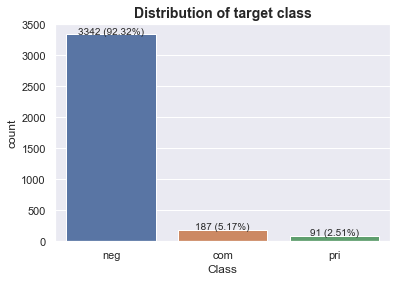

In [20]:
show_class_histogram(df)

In [21]:
target = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Class', axis=1), target, stratify=target, random_state=42
)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_onehot = np_utils.to_categorical(encoder.transform(y_train))
y_test_onehot = np_utils.to_categorical(encoder.transform(y_test))

In [23]:
print('X_train shape:', X_train.shape)
print('y_train_onehot shape:', y_train_onehot.shape)
print('X_test shape:', X_test.shape)
print('y_test_onehot shape:', y_test_onehot.shape)

num_classes = y_train_onehot.shape[1]
print('Number of classes:', num_classes)

X_train shape: (2715, 25)
y_train_onehot shape: (2715, 3)
X_test shape: (905, 25)
y_test_onehot shape: (905, 3)
Number of classes: 3


## TensorFlow model for Thyroid dataset

For multiclass classification we use softmax output activation and corresponding loss function.

In [24]:
batch_size = 20
learning_rate = 0.01
alpha = 0.001    # regularization
n_epochs = 100

In [25]:
tf.reset_default_graph()

num_examples = X_train.shape[0]
num_input_neurons = X_train.shape[1]

# Step 2: create placeholders for features and labels
X = tf.placeholder(tf.float32, [batch_size, num_input_neurons], name='image') 
Y = tf.placeholder(tf.float32, [batch_size, num_classes], name='label')

# Step 3: create weights and bias
w = tf.get_variable(name='weights', shape=(num_input_neurons, num_classes), initializer=tf.random_normal_initializer())
b = tf.get_variable(name='bias', shape=(1, num_classes), initializer=tf.zeros_initializer())

# Step 4: build model
logits = tf.matmul(X, w) + b 

# Step 5: define loss function
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y, name='loss')
loss = tf.reduce_mean(entropy) + alpha * tf.nn.l2_loss(w)

# Step 6: define training op
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Step 7: calculate accuracy with test set
preds = tf.nn.softmax(logits)
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))


def fit_epoch(X_data, y_data):
    num_examples = X_data.shape[0]
    n_batches = int(num_examples/batch_size)
    
    for j in range(n_batches):
        X_batch = X_data[batch_size * j: batch_size * (j + 1)]
        Y_batch = y_data[batch_size * j: batch_size * (j + 1)]
        #Y_batch = Y_batch.values.reshape(Y_batch.shape[0], 1)
        sess.run([optimizer], {X: X_batch, Y:Y_batch})

    
def evaluate(X_data, y_data):
    num_examples = X_data.shape[0]
    n_batches = int(num_examples/batch_size)
    
    total_loss = 0
    total_correct_preds = 0

    for i in range(n_batches):
        
        X_batch = X_data[batch_size * i: batch_size * (i + 1)]
        Y_batch = y_data[batch_size * i: batch_size * (i + 1)]
        #Y_batch = Y_batch.values.reshape(Y_batch.shape[0], 1)

        loss_batch, accuracy_batch = sess.run([loss, accuracy], {X: X_batch, Y:Y_batch})
        total_loss += loss_batch
        total_correct_preds += accuracy_batch
    
    return total_loss, total_correct_preds/num_examples

In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    
    history = TrainingHistory()

    for i in range(n_epochs): 
        fit_epoch(X_train, y_train_onehot)

        train_loss, train_accuracy = evaluate(X_train, y_train_onehot)
        test_loss, test_accuracy = evaluate(X_test, y_test_onehot)

        history.train_loss_list.append(train_loss)
        history.train_metric_list.append(train_accuracy)
        history.test_loss_list.append(test_loss)
        history.test_metric_list.append(test_accuracy)

        if i % 10 == 0:
            print('Epoch {0}: loss={1} accuracy={2}'.format(i, train_loss, train_accuracy))

Epoch 0: loss=215.574098944664 accuracy=0.7244935543278085
Epoch 10: loss=21.583501756191254 accuracy=0.9447513812154696
Epoch 20: loss=19.56972160190344 accuracy=0.9502762430939227
Epoch 30: loss=18.826012190431356 accuracy=0.9528545119705341
Epoch 40: loss=18.5679832957685 accuracy=0.9539594843462247
Epoch 50: loss=18.474485151469707 accuracy=0.9535911602209944
Epoch 60: loss=18.436928529292345 accuracy=0.9535911602209944
Epoch 70: loss=18.42042487114668 accuracy=0.9535911602209944
Epoch 80: loss=18.412731923162937 accuracy=0.9535911602209944
Epoch 90: loss=18.408993404358625 accuracy=0.9535911602209944


Accuracy: train=0.9536, test=0.9547
Loss: train=18.4072, test=6.3635


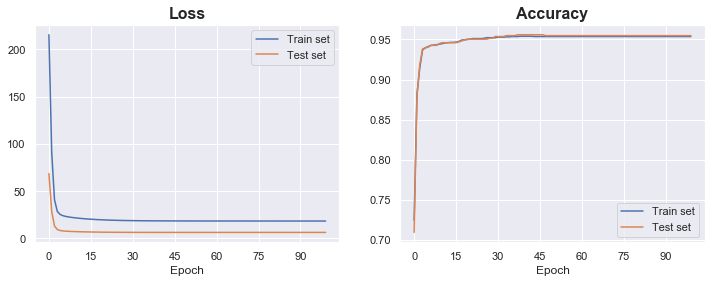

In [27]:
history.print_scores()
history.plot()
plt.show()

## Keras model for Thyroid dataset

In [28]:
from keras import backend as K; K.clear_session() # TODO: fix this
tf.reset_default_graph()

adam = keras.optimizers.Adam()

model = Sequential()
model.add(Dense(num_classes, input_dim=X_train.shape[1], activation='softmax', activity_regularizer=l2(0.01)))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=adam)

history = TrainingHistory(metric='categorical_accuracy', metric_name='Accuracy')

model.fit(
    X_train, y_train_onehot, epochs=100, batch_size=batch_size, verbose=0,
    validation_data=(X_test, y_test_onehot),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)

score, accuracy = model.evaluate(X_train, y_train_onehot, batch_size=batch_size, verbose=0)
print("\nTrain Loss = {:.2f}".format(score))
print("Train Accuracy = {:.2f}".format(accuracy))

score, accuracy = model.evaluate(X_test, y_test_onehot, batch_size=batch_size, verbose=0)
print("\nTest Loss = {:.2f}".format(score))
print("Test Accuracy = {:.2f}".format(accuracy))

Epoch 10: loss=0.4618397047177204 categorical_accuracy=0.9440
Epoch 20: loss=0.3764097401340583 categorical_accuracy=0.9466
Epoch 30: loss=0.3506357973890849 categorical_accuracy=0.9488
Epoch 40: loss=0.3372403553946023 categorical_accuracy=0.9506
Epoch 50: loss=0.3284057642214865 categorical_accuracy=0.9529
Epoch 60: loss=0.321112976219114 categorical_accuracy=0.9551
Epoch 70: loss=0.31410916876836814 categorical_accuracy=0.9584
Epoch 80: loss=0.30790871691857474 categorical_accuracy=0.9602
Epoch 90: loss=0.30288933631903997 categorical_accuracy=0.9624
Epoch 100: loss=0.29895941367026413 categorical_accuracy=0.9628

Train Loss = 0.30
Train Accuracy = 0.96

Test Loss = 0.31
Test Accuracy = 0.96


Accuracy: train=0.9628, test=0.9613
Loss: train=0.2990, test=0.3099


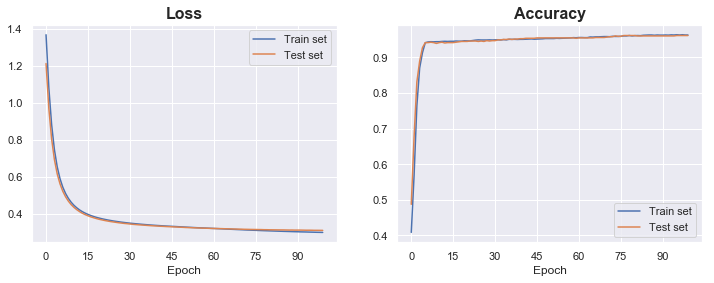

In [29]:
history.print_scores()
history.plot()
plt.show()

# Boston houses

## Preprocessing

Here we apply scaling and split the data into train/test set.

In [30]:
from sklearn.datasets import load_boston
boston = load_boston()

X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(boston['data'], columns=boston['feature_names']),
    boston['target']
)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Keras regression model for Boston houses

Differences from classification neural networks:
- linear output activation
- mean squared error as loss function
- R2-score was chosen as metric

Epoch 10: loss=38.5599610170148 r2=0.2686
Epoch 20: loss=33.442525549111075 r2=0.3929
Epoch 30: loss=22.764345488636348 r2=0.5903
Epoch 40: loss=25.758898261983664 r2=0.5190
Epoch 50: loss=21.663766936450646 r2=0.6257
Epoch 60: loss=21.512211472503743 r2=0.6002
Epoch 70: loss=22.230478520758233 r2=0.5797
Epoch 80: loss=21.534122507301674 r2=0.6274
Epoch 90: loss=17.49557509082603 r2=0.7010
Epoch 100: loss=16.563648824012375 r2=0.6667
Epoch 110: loss=17.8668845083594 r2=0.6944
Epoch 120: loss=17.86139146885331 r2=0.6783
Epoch 130: loss=14.568876270253929 r2=0.7203
Epoch 140: loss=14.572056990500176 r2=0.7506
Epoch 150: loss=13.97302929266776 r2=0.7537
Epoch 160: loss=15.792144630703888 r2=0.7258
Epoch 170: loss=13.485615010626399 r2=0.7798
Epoch 180: loss=14.197553468568344 r2=0.7931
Epoch 190: loss=16.067052473808026 r2=0.7241
Epoch 200: loss=12.483591761626794 r2=0.7524

R2-score: train=0.7524, test=0.7388
Loss: train=12.4836, test=12.1950


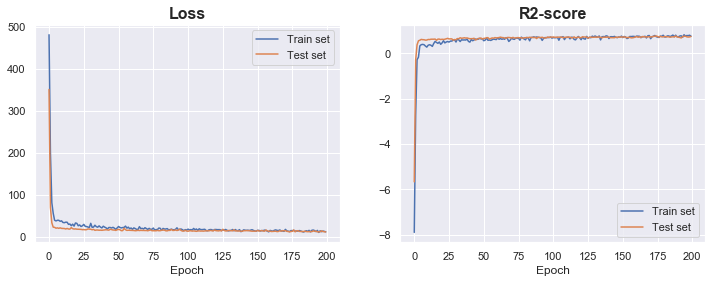

In [36]:
from keras import backend as K; K.clear_session()
tf.reset_default_graph()

adam = keras.optimizers.Adam()

from keras import backend as K

def r2(y_true, y_pred):
    """ R2 metric for regression. """
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = Sequential()
model.add(Dense(40, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', metrics=[r2], optimizer=adam)

history = TrainingHistory(metric='r2', metric_name='R2-score')

model.fit(
    X_train, y_train, epochs=200, batch_size=10, verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)

print()
history.print_scores()
history.plot()
plt.show()

# The end.